# Goal:
由于健康模型在高胆数据上预测准确率低，需要从数据的角度上描述（健康、高胆换血、高胆未换血）的差异。
1. 找到论文里一般用的特征有哪些，做差异分析
2. 用这些特征建立机器学习模型，看feature importance，比较哪个特征贡献大。


In [1]:
import os
import copy
import pylab
import math
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import mne 
from multiprocessing import Pool
import threading
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu

mne.set_log_level('ERROR')

In [2]:
import matplotlib.font_manager
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams["figure.dpi"] = 100
plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually
#%matplotlib tk
import inspect
inspect.getfullargspec(mne.io.read_raw_edf)

FullArgSpec(args=['input_fname', 'eog', 'misc', 'stim_channel', 'exclude', 'infer_types', 'include', 'preload', 'units', 'encoding'], varargs=None, varkw=None, defaults=(None, None, 'auto', (), False, None, False, None, 'utf8'), kwonlyargs=['verbose'], kwonlydefaults={'verbose': None}, annotations={})

In [3]:
def readPath(path):
    file_path = []
    for root, dirs, files in os.walk(path):
        
        for file in files:
            if file.endswith('.edf'):
                path_name = os.path.join(root, file)
                file_path.append(path_name)
            #print(path_name)

    return file_path

In [4]:
def loadFile(path, exclude_channels=True, 
                             crop_wake_mins=30):
    """Load a raw.edf file.

    Parameters
    ----------
    path : str
        Path to the .edf file containing the raw data. 
    exclude_channels : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.

    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """

    mapping = {
    # 'EEG Fp1-AV',
    # 'EEG Fp2-AV',
     'EEG C3-AV',
     'EEG C4-AV',
    # 'EEG P3-AV',
     'EEG O1-AV',
     'EEG T3-AV',
     'EEG T4-AV',
     'EEG Cz-AV',
     'EEG Pz-AV',
     'EEG O2-AV',
    # 'EEG P4-AV',
     'ECG',
     'EMG Left_Leg',
     'EMG Right_Leg'}

    
    exclude = mapping if exclude_channels else ()

    #Read the raw data and annotations
    raw = mne.io.read_raw_edf(path, exclude=exclude)

    if not exclude_channels:
        raw.set_channel_types(mapping)

    # Rename EEG channel: replace EEG
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)


    #store the subject information:
    
    basename = os.path.basename(path)
    subj_nb = os.path.splitext(basename)[0] #e.g., 113
    raw.info['subject_info'] = {'id': subj_nb}
    

    return raw

In [5]:
path_1 = './healthy-2023'
path_2 = './healthy-2024'
path_3 = './hyper-bloodchange-2024'
path_4 = './hyper-blood-change-notchange-sample'

In [6]:
res_1 = readPath(path_1) #healthy - from 2023
res_4 = readPath(path_4) #高胆红素血症（换血及未换血各3个）

In [7]:
raws_healthy = [loadFile(f) for f in res_1] #healthy dataset
raws_hyper_6 = [loadFile(f) for f in res_4] #hyper: blood exchanged vs not (6)

The datasets we have:
- raws_healthy
- raws_hyper_26
- raws_hyper_6

# Filter

In [8]:
def filter(raw):
    l_freq, h_freq = None, 30
    raw.load_data().filter(l_freq, h_freq)  # filtering happens in-place 

In [9]:
for raw in raws_healthy:
    filter(raw)

In [10]:
for raw in raws_hyper_6:
    filter(raw)

# Extract epochs

In [11]:
def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.
    
    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    custom_mapping = {"清醒1": 3, "AS1":2, "QS1":1}
    events, _ = mne.events_from_annotations(
        raw, 
        event_id=custom_mapping, 
        chunk_duration=chunk_duration)


    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=custom_mapping, tmin=0., tmax=tmax, baseline=None)
    
    return epochs

### Get epoch lists for datasets with annotations:
Datasets:
- raws_healthy
- raws_hyper_6

Output epochs:
- epochs_healthy
- epochs_hyper_6

In [12]:
#对MyThread进行封装
class MyThread(threading.Thread):
    def __init__(self,func,args,name=''):
        threading.Thread.__init__(self)
        self.func = func
        self.name = name
        self.args = args
        self.res = None
    def run(self):
        self.res = self.func(self.args)
    def getResult(self):
        return self.res

In [13]:
if __name__ == '__main__' :
    Threads = []
    epochs_healthy = []
    i = 0
    for raw in raws_healthy:
        t = MyThread(func=extract_epochs,args=raw,name ='Thread'+ str(i))
        i+=1
        Threads.append(t)
        t.start()
    for t in Threads:
        t.join()
        epochs_healthy.append(t.getResult()) #epochs_all would be the dataset of all epochs

In [14]:
if __name__ == '__main__' :
    Threads = []
    epochs_hyper_6 = []
    i = 0
    for raw in raws_hyper_6:
        t = MyThread(func=extract_epochs,args=raw,name ='Thread'+ str(i))
        i+=1
        Threads.append(t)
        t.start()
    for t in Threads:
        t.join()
        epochs_hyper_6.append(t.getResult()) #epochs_all would be the dataset of all epochs

### Get epoch lists for datasets without annotations:

- raws_hyper_26

In [15]:
print(epochs_healthy)
print(epochs_hyper_6)

[<Epochs |  784 events (all good), 0 – 29.998 s, baseline off, ~358.9 MB, data loaded,
 '清醒1': 226
 'AS1': 277
 'QS1': 281>, <Epochs |  479 events (all good), 0 – 29.998 s, baseline off, ~219.3 MB, data loaded,
 '清醒1': 252
 'AS1': 106
 'QS1': 121>, <Epochs |  472 events (all good), 0 – 29.998 s, baseline off, ~216.1 MB, data loaded,
 '清醒1': 90
 'AS1': 267
 'QS1': 115>, <Epochs |  363 events (all good), 0 – 29.998 s, baseline off, ~166.2 MB, data loaded,
 '清醒1': 92
 'AS1': 165
 'QS1': 106>, <Epochs |  469 events (all good), 0 – 29.998 s, baseline off, ~214.7 MB, data loaded,
 '清醒1': 136
 'AS1': 244
 'QS1': 89>, <Epochs |  547 events (all good), 0 – 29.998 s, baseline off, ~250.4 MB, data loaded,
 '清醒1': 263
 'AS1': 201
 'QS1': 83>, <Epochs |  472 events (all good), 0 – 29.998 s, baseline off, ~216.1 MB, data loaded,
 '清醒1': 86
 'AS1': 240
 'QS1': 146>, <Epochs |  486 events (all good), 0 – 29.998 s, baseline off, ~222.5 MB, data loaded,
 '清醒1': 139
 'AS1': 196
 'QS1': 151>, <Epochs |  4

# Feature Engineering

Observe the PSD plot of the epochs of each dataset:
- grouped by sleep staging (epochs_healthy, epochs_hyper_6)

#### Frequency analysis: Sleep stages x per subject x electrode positions

Based on the 10-20 international system of electrode placement and the electodes we have: <br>
Our electrodes can be arranged into: <br>
- Frontal lobe: FP1, FP2 (picks: 0,1)
- Parietal lobe: C3, Cz, C4, P3, Pz, P4 (picks: 2,10,3,4,11,5)
- Temporal lobe: T7, T8 (picks: 8,9)
- Occipital lobe: O1, O2 (picks: 6,7)

Next, we can plot epochs of each sleep stage as an image map: <br>
1. each row of pixels in the image representing a single epoch
2. the horizontal axis representing time
3. each pixel's color representing the signal value at that time sample for that epoch

We saved the image maps.

In [16]:
def eeg_analysis(epochs,picks,event):
    """
    Parameters
    ------------
    epochs : Epochs
        The data
    picks : Channels
        Channels that uses for analys
    event : sleep stage
        Sleep stage uses for analys

    Returns
    -----------
    subplots
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],# qs
        "theta": [4.5, 8.5],# as
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }
    spectrum = epochs[event].compute_psd(picks=picks,fmin=0.5,fmax=30.0)
    psds,freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    power_bands = []
    index = 0
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        power_bands.append(psds_band.reshape(len(psds), -1))
    return power_bands

In [17]:
def powerband_plotting(healthy_pb,hyper6_pb,N,event,picks):
     # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],# qs
        "theta": [4.5, 8.5],# as
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }
    # plotting
    # 创建一个新的图形，设置子图的布局  
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))  # 5行2列的子图
    # 遍历数据并绘制到子图上  
    for i in range(10):  
        # 计算子图的索引（行和列）  
        row = i // 2 
        col = i % 2 
        # 获取当前子图  
        ax = axs[row, col]  
        # 绘制数据  
        if(col == 0):
            ax.plot(healthy_pb[N][row])
            ax.set_title('健康宝宝:'+list(FREQ_BANDS.keys())[row])
        elif col ==1 and N <3:
            ax.plot(hyper6_pb[N][row])
            ax.set_title('换血宝宝:'+list(FREQ_BANDS.keys())[row])
        elif col == 1 and N >=3:
            ax.plot(hyper6_pb[N][row])
            ax.set_title('未换血宝宝:'+list(FREQ_BANDS.keys())[row])
        # 设置y轴标签  
        ax.set_ylabel(f'Subplot {i+1}')  
      
    # 设置图形的标题  
    fig.suptitle('5波段 '+event+' 阶段在 '+picks[0]+','+picks[1]+' 频道健康与换血宝宝对比')

    plt.tight_layout()

    plt.savefig('.\\saved_analysis_result\\'+event+'\\babyset'+str(N)+'.png')
    plt.show()

# Powerbands analyz

In [18]:
sleep_stage = ['AS1','QS1','清醒1']
picks = ['Fp1-AV','Fp2-AV']
waves = ['Δ波','θ波','α波','σ波','β波']

In [19]:
def manwhitneyu_analyz(powerbands,N):
    wave = []
    subject_1 = []
    subject_2 = []
    statistic = []
    p_value = []
    for i in range(len(waves)):
        for j in range(len(powerbands)):
            k = j + 1
            while k < len(powerbands):
                wave.append(waves[i])
                subject_1.append(j+1)
                subject_2.append(k+1)
                statistic.append(mannwhitneyu(powerbands[j][i][:,N],powerbands[k][i][:,N])[0])
                p_value.append(mannwhitneyu(powerbands[j][i][:,N],powerbands[k][i][:,N])[1])
                k+=1
    df = pd.DataFrame({'wave':wave, 'subject_1':subject_1, 'subject_2':subject_2, 'statistic':statistic, 'p_value':p_value})
    pd.set_option('display.max_rows', None)
    return df

In [20]:
def pick_classic(diff_list):
    new_diff_list = diff_list.copy()
    new_diff_list.sort()
    values = new_diff_list
    result = []
    for value in values:
        index = np.where(diff_list == value)
        result.append(index[0].tolist())
    return result

In [21]:
healthy_qs_all = []
healthy_as_all = []
healthy_awake_all = []
for healthy in epochs_healthy:
    healthy_qs_all.append(eeg_analysis(healthy,picks,sleep_stage[0]))
    healthy_as_all.append(eeg_analysis(healthy,picks,sleep_stage[1]))
    healthy_awake_all.append(eeg_analysis(healthy,picks,sleep_stage[2]))

In [22]:
healthy_qs_df = manwhitneyu_analyz(healthy_qs_all,0)
healthy_as_df = manwhitneyu_analyz(healthy_as_all,0)
healthy_awake_df = manwhitneyu_analyz(healthy_awake_all,0)

In [23]:
diff_qs_df = healthy_qs_df[healthy_qs_df['p_value']>=0.05]
diff_as_df = healthy_as_df[healthy_as_df['p_value']>=0.05]
diff_awake_df = healthy_awake_df[healthy_awake_df['p_value']>=0.05]

In [24]:
diff_qs_df

wave  subject_1  subject_2  statistic   p_value
14     Δ波          1         16    37374.0  0.136008
17     Δ波          1         19    19647.0  0.174815
22     Δ波          1         24    15378.0  0.139500
24     Δ波          2          4     7903.0  0.181389
33     Δ波          2         13     7746.0  0.050105
41     Δ波          2         21      370.0  0.995352
43     Δ波          2         23     7520.0  0.085916
65     Δ波          3         24    12006.0  0.104811
74     Δ波          4         13    13540.0  0.584585
79     Δ波          4         18    10527.0  0.055181
82     Δ波          4         21      570.0  0.957676
84     Δ波          4         23    13000.0  0.669792
94     Δ波          5         14    21653.0  0.446138
95     Δ波          5         15    28433.0  0.269518
108    Δ波          6         10    28934.0  0.147057
115    Δ波          6         17    51674.0  0.558243
118    Δ波          6         20    21845.0  0.227926
120    Δ波          6         22     4515.0  0.367526
123    Δ波          7          8    22841.0  0.604178
129    Δ波          7         14    19107.0  0.274228
137    Δ波          7         22     6643.0  0.152630
145    Δ波          8         14    15510.0  0.254823
146    Δ波          8         15    19572.0  0.104452
153    Δ波          8         22     5370.0  0.200905
166    Δ波          9         20    25929.0  0.412603
168    Δ波          9         22     5323.0  0.827858
173    Δ波         10         13    24285.0  0.216865
178    Δ波         10         18    21469.0  0.088157
181    Δ波         10         21     1220.0  0.172116
182    Δ波         10         22     5392.0  0.050647
204    Δ波         12         19     5772.0  0.303251
214    Δ波         13         18    11611.0  0.324068
217    Δ波         13         21      606.0  0.938370
218    Δ波         13         22     3427.0  0.059133
219    Δ波         13         23    14014.0  0.780599
221    Δ波         14         15    18824.0  0.910922
228    Δ波         14         22     4746.0  0.137424
237    Δ波         15         22     6227.0  0.089414
247    Δ波         16         24    12853.0  0.837600
250    Δ波         17         20    58867.0  0.324008
252    Δ波         17         22    12055.0  0.418381
257    Δ波         18         21      578.0  0.569096
259    Δ波         18         23    12545.0  0.357222
265    Δ波         19         24     8785.0  0.080288
267    Δ波         20         22     5470.0  0.646473
270    Δ波         21         22      103.0  0.092501
271    Δ波         21         23      514.0  0.684963
285    θ波          1         11    21421.0  0.212524
286    θ波          1         12     8571.0  0.185190
290    θ波          1         16    36399.0  0.350352
298    θ波          1         24    13041.0  0.313722
300    θ波          2          4     9603.0  0.173229
314    θ波          2         18     8180.0  0.439573
317    θ波          2         21      401.0  0.730835
329    θ波          3         12     9708.0  0.490466
336    θ波          3         19    19094.0  0.223266
341    θ波          3         24    14158.0  0.459208
350    θ波          4         13    15286.0  0.154933
355    θ波          4         18    11587.0  0.563212
358    θ波          4         21      593.0  0.909451
364    θ波          5          8    25513.0  0.227329
371    θ波          5         15    25830.0  0.483961
394    θ波          6         20    23209.0  0.873772
400    θ波          7          9    24519.0  0.454348
405    θ波          7         14    19636.0  0.518360
411    θ波          7         20    30619.0  0.073652
422    θ波          8         15    19291.0  0.063854
426    θ波          8         19    16483.0  0.138911
436    θ波          9         14    18307.0  0.851511
444    θ波          9         22     4285.0  0.051084
449    θ波         10         13    20731.0  0.127141
453    θ波         10         17    73103.0  0.417919
457    θ波         10         21      597.0  0.104422
458    θ波         10         22     6919.0  0.521340
459    θ波         10         2

In [25]:
diff_as_df

wave  subject_1  subject_2  statistic   p_value
22     Δ波          1         24    10578.0  0.765473
26     Δ波          2          6     4643.0  0.361460
30     Δ波          2         10    11246.0  0.516101
40     Δ波          2         20     8188.0  0.066170
43     Δ波          2         23    11756.0  0.562552
46     Δ波          3          5     4777.0  0.416156
49     Δ波          3          8     7969.0  0.251356
52     Δ波          3         11     6368.0  0.184719
56     Δ波          3         15     6083.0  0.548476
58     Δ波          3         17    21200.0  0.052620
74     Δ波          4         13     9820.0  0.320004
82     Δ波          4         21     2666.0  0.161049
88     Δ波          5          8     6572.0  0.777212
91     Δ波          5         11     5290.0  0.678033
95     Δ波          5         15     4949.0  0.230040
97     Δ波          5         17    17486.0  0.374494
108    Δ波          6         10     8381.0  0.080243
112    Δ波          6         14     9316.0  0.410025
121    Δ波          6         23     8841.0  0.068123
137    Δ波          7         22     7769.0  0.392759
142    Δ波          8         11     9183.0  0.874553
146    Δ波          8         15     8458.0  0.142308
148    Δ波          8         17    30402.0  0.504187
161    Δ波          9         15     5067.0  0.157627
180    Δ波         10         20    11847.0  0.083439
183    Δ波         10         23    16649.0  0.995645
188    Δ波         11         15     6988.0  0.107866
190    Δ波         11         17    25069.0  0.675698
192    Δ波         11         19     9271.0  0.070516
228    Δ波         14         22    11098.0  0.300784
241    Δ波         16         18    23655.0  0.168456
247    Δ波         16         24     5676.0  0.094959
255    Δ波         18         19    23514.0  0.293753
266    Δ波         20         21     3929.0  0.135611
282    θ波          1          8    18913.0  0.062827
290    θ波          1         16    26158.0  0.090240
298    θ波          1         24    11604.0  0.329215
306    θ波          2         10    10216.0  0.451487
310    θ波          2         14    15590.0  0.225703
316    θ波          2         20     8226.0  0.056400
322    θ波          3          5     4388.0  0.081264
323    θ波          3          6     4044.0  0.067277
326    θ波          3          9     5874.0  0.210918
332    θ波          3         15     5093.0  0.119249
335    θ波          3         18    13596.0  0.197771
350    θ波          4         13     9081.0  0.893588
362    θ波          5          6     3488.0  0.529883
365    θ波          5          9     5300.0  0.511169
371    θ波          5         15     4490.0  0.991563
374    θ波          5         18    12058.0  0.479894
383    θ波          6          9     5220.0  0.176795
389    θ波          6         15     4261.0  0.847793
391    θ波          6         17    16420.0  0.441861
392    θ波          6         18    11485.0  0.319618
393    θ波          6         19     6476.0  0.230659
437    θ波          9         15     5402.0  0.501411
440    θ波          9         18    14817.0  0.801097
468    θ波         11         19    11530.0  0.187787
477    θ波         12         16     4028.0  0.175926
485    θ波         12         24     1764.0  0.141411
502    θ波         14         20    15191.0  0.292992
508    θ波         15         17    18719.0  0.077289
509    θ波         15         18    13460.0  0.626327
510    θ波         15         19     7607.0  0.086819
523    θ波         16         24     6486.0  0.910448
525    θ波         17         19    33813.0  0.256655
543    θ波         20         22     6436.0  0.298605
549    θ波         22         23     9528.0  0.791044
555    α波          1          5    10937.0  0.074738
572    α波          1         22    12934.0  0.238224
575    α波          2          3     6688.0  0.607861
579    α波          2          7     8735.0  0.876645
580    α波          2          8     9154.0  0.977727
581    α波          2          9     6113.0  0.162349
587    α波          2         1

In [26]:
diff_awake_df

wave  subject_1  subject_2  statistic   p_value
1      Δ波          1          3    10163.0  0.992925
13     Δ波          1         15    12904.0  0.152685
16     Δ波          1         18     8538.0  0.528334
17     Δ波          1         19    16096.0  0.539369
22     Δ波          1         24    30117.0  0.860043
33     Δ波          2         13    16806.0  0.503195
56     Δ波          3         15     5234.0  0.155832
59     Δ波          3         18     3463.0  0.453278
60     Δ波          3         19     6558.0  0.843778
65     Δ波          3         24    12110.0  0.995787
67     Δ波          4          6    12964.0  0.306993
69     Δ波          4          8     7007.0  0.218012
82     Δ波          4         21    18284.0  0.866586
83     Δ波          4         22    12996.0  0.228627
84     Δ波          4         23     4653.0  0.986620
87     Δ波          5          7     6425.0  0.216247
90     Δ波          5         10     4086.0  0.226495
92     Δ波          5         12    24443.0  0.867944
95     Δ波          5         15     6524.0  0.304298
97     Δ波          5         17    35184.0  0.582745
98     Δ波          5         18     4170.0  0.078954
106    Δ波          6          8    18323.0  0.968324
121    Δ波          6         23    11572.0  0.057264
125    Δ波          7         10     2364.0  0.858992
127    Δ波          7         12    15001.0  0.773117
130    Δ波          7         15     3938.0  0.157369
131    Δ波          7         16     3742.0  0.201983
132    Δ波          7         17    20069.0  0.297516
154    Δ波          8         23     6219.0  0.131908
159    Δ波          9         13     8503.0  0.143034
172    Δ波         10         12     9370.0  0.765992
175    Δ波         10         15     2409.0  0.144055
176    Δ波         10         16     2325.0  0.311882
177    Δ波         10         17    12348.0  0.282515
182    Δ波         10         22     9640.0  0.062055
193    Δ波         11         20     3650.0  0.432958
202    Δ波         12         17    90013.0  0.854367
226    Δ波         14         20     3882.0  0.135002
232    Δ波         15         17    28394.0  0.158876
233    Δ波         15         18     3531.0  0.522556
234    Δ波         15         19     6805.0  0.118004
239    Δ波         15         24    12416.0  0.092381
245    Δ波         16         22    12814.0  0.362519
246    Δ波         16         23     4475.0  0.119286
255    Δ波         18         19     4977.0  0.428828
260    Δ波         18         24     9080.0  0.416624
265    Δ波         19         24    20326.0  0.721670
270    Δ波         21         22    58674.0  0.232547
271    Δ波         21         23    20836.0  0.682314
273    Δ波         22         23    16780.0  0.234554
286    θ波          1         12    41873.0  0.405530
289    θ波          1         15    12710.0  0.234372
293    θ波          1         19    15703.0  0.318199
328    θ波          3         11     9421.0  0.435825
331    θ波          3         14    11061.0  0.186350
332    θ波          3         15     4210.0  0.228649
341    θ波          3         24    10588.0  0.075167
362    θ波          5          6    16054.0  0.093835
366    θ波          5         10     4208.0  0.117285
374    θ波          5         18     4739.0  0.704716
391    θ波          6         17    64487.0  0.599247
392    θ波          6         18     9604.0  0.852376
397    θ波          6         23    12200.0  0.229120
399    θ波          7          8     6545.0  0.231681
409    θ波          7         18     3359.0  0.359434
413    θ波          7         22    11658.0  0.089511
414    θ波          7         23     4586.0  0.510939
425    θ波          8         18     5266.0  0.534007
430    θ波          8         23     7027.0  0.989482
443    θ波          9         21    26950.0  0.090542
444    θ波          9         22    23306.0  0.696734
452    θ波         10         16     2103.0  0.990768
454    θ波         10         18     1789.0  0.446270
455    θ波         10         19     4353.0  0.332266
464    θ波         11         1

In [27]:
def diff_list(diff_df):
    diff_list =  np.zeros(24)
    for i in range(len(diff_df)):
        s1 = diff_df.iloc[i,1]
        s2 = diff_df.iloc[i,2]
        diff_list[s1-1]+=1
        diff_list[s2-1]+=1
    return diff_list

In [28]:
diff_qs_list = diff_list(diff_qs_df)

In [29]:
diff_as_list = diff_list(diff_as_df)

In [30]:
diff_awake_list = diff_list(diff_awake_df)

In [31]:
print(diff_qs_list)
print(diff_as_list)
print(diff_awake_list)

[19. 29. 19. 30. 22. 12. 17. 25. 18. 23.  7. 14. 29. 18. 24. 21. 25. 21.
 10. 15. 58. 36. 13. 21.]
[10. 28. 26. 12. 26. 16. 21. 17. 14. 22. 12.  5. 17. 12. 32. 19. 11. 16.
 10. 11. 24. 21. 10. 18.]
[15. 10. 28. 15. 21. 13. 25. 13.  5. 31.  3. 26. 11.  9. 43. 18. 22. 25.
 17. 14. 15. 24. 24. 23.]


In [32]:
qs_pick = pick_classic(diff_qs_list)
as_pick = pick_classic(diff_as_list)
awake_pick = pick_classic(diff_awake_list)

In [33]:
print (qs_pick)
print (as_pick)
print (awake_pick)

[[10], [18], [5], [22], [11], [19], [6], [8, 13], [8, 13], [0, 2], [0, 2], [15, 17, 23], [15, 17, 23], [15, 17, 23], [4], [9], [14], [7, 16], [7, 16], [1, 12], [1, 12], [3], [21], [20]]
[[11], [0, 18, 22], [0, 18, 22], [0, 18, 22], [16, 19], [16, 19], [3, 10, 13], [3, 10, 13], [3, 10, 13], [8], [5, 17], [5, 17], [7, 12], [7, 12], [23], [15], [6, 21], [6, 21], [9], [20], [2, 4], [2, 4], [1], [14]]
[[10], [8], [13], [1], [12], [5, 7], [5, 7], [19], [0, 3, 20], [0, 3, 20], [0, 3, 20], [18], [15], [4], [16], [23], [21, 22], [21, 22], [6, 17], [6, 17], [11], [2], [9], [14]]


In [34]:
final_pick = []
for i in range(6):
    final_pick.append(qs_pick[i][0])

In [35]:
final_pick=[0,8,10,11,12,13]

# 数据分割

In [113]:
healthy_powerbands = []
hyper6_powerbands = []
selected_healthy_powerbands = []
for i in range(6):
    selected_healthy_powerbands.append(eeg_analysis(epochs_healthy[final_pick[i]],picks,sleep_stage[1]))
    hyper6_powerbands.append(eeg_analysis(epochs_hyper_6[i],picks,sleep_stage[1]))
    healthy_powerbands.append(eeg_analysis(epochs_healthy[i],picks,sleep_stage[1]))

In [37]:
# data_healthy,data_exchanged,data_unexchanged = [],[],[]
# for i in range(6):
#     data_healthy.extend(healthy_powerbands[i][0][:,0])
# for i in range(3):
#     data_exchanged.extend(hyper6_powerbands[i][0][:,0])
#     data_unexchanged.extend(hyper6_powerbands[i+3][0][:,0])
# data = {'group1':data_healthy,'group2':data_exchanged,'group3':data_unexchanged}
# model = ols('group',data=data).fit()

# df = pd.DataFrame(data)
# result = pg.anova(data=df.melt(var_name='group',value_name='value'),dv='value',between='group')
# print(result)

# 统合作图

In [38]:
def powerband_plotting_allin1(powerband,event,picks,health):
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],# qs
        "theta": [4.5, 8.5],# as
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }
    # plotting
    # 创建一个新的图形，设置子图的布局  
    fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(30, 15))  # 5行2列的子图
    for i in range(30):
        row = i//6
        col = i%6
        ax= axs[row,col]
        ax.plot(powerband[col][row])
        ax.set_title(str(col)+'宝宝：'+list(FREQ_BANDS.keys())[row])
    fig.suptitle(health+"宝宝在 " + event+" 阶段 " + picks[0]+','+picks[1]+" 频道5波段合集")
    plt.tight_layout()
    plt.savefig('.\\saved_analysis_result\\'+event+'\\'+health+'宝宝合集.png',dpi=600,bbox_inches='tight')
    plt.show()


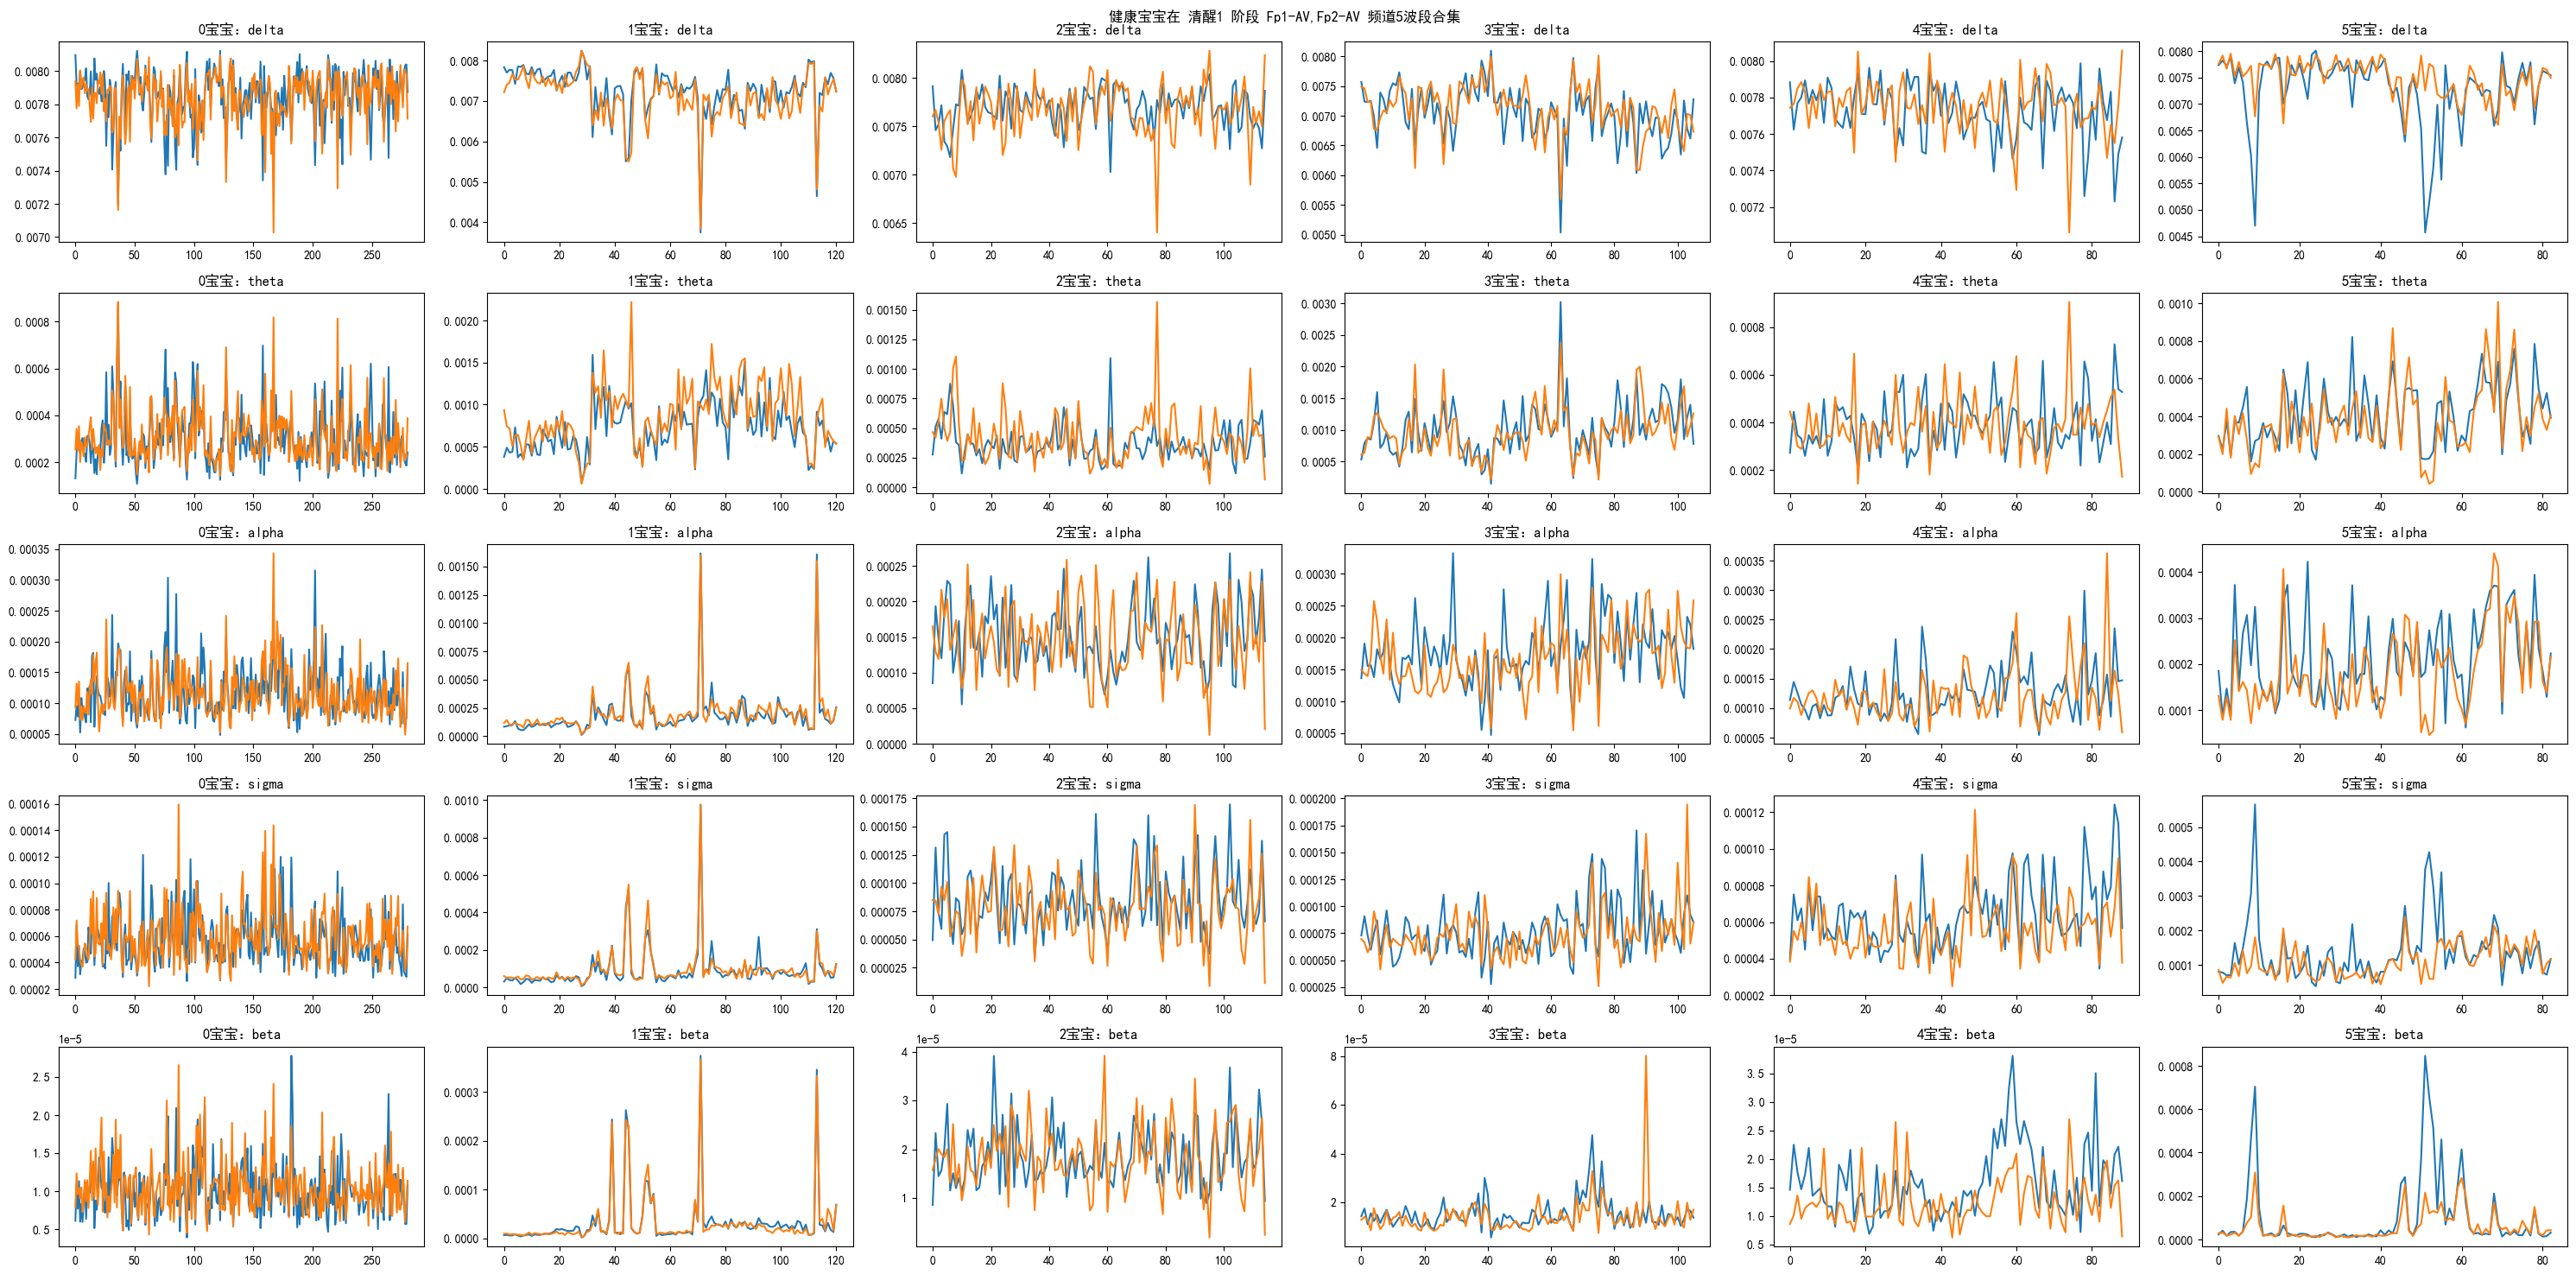

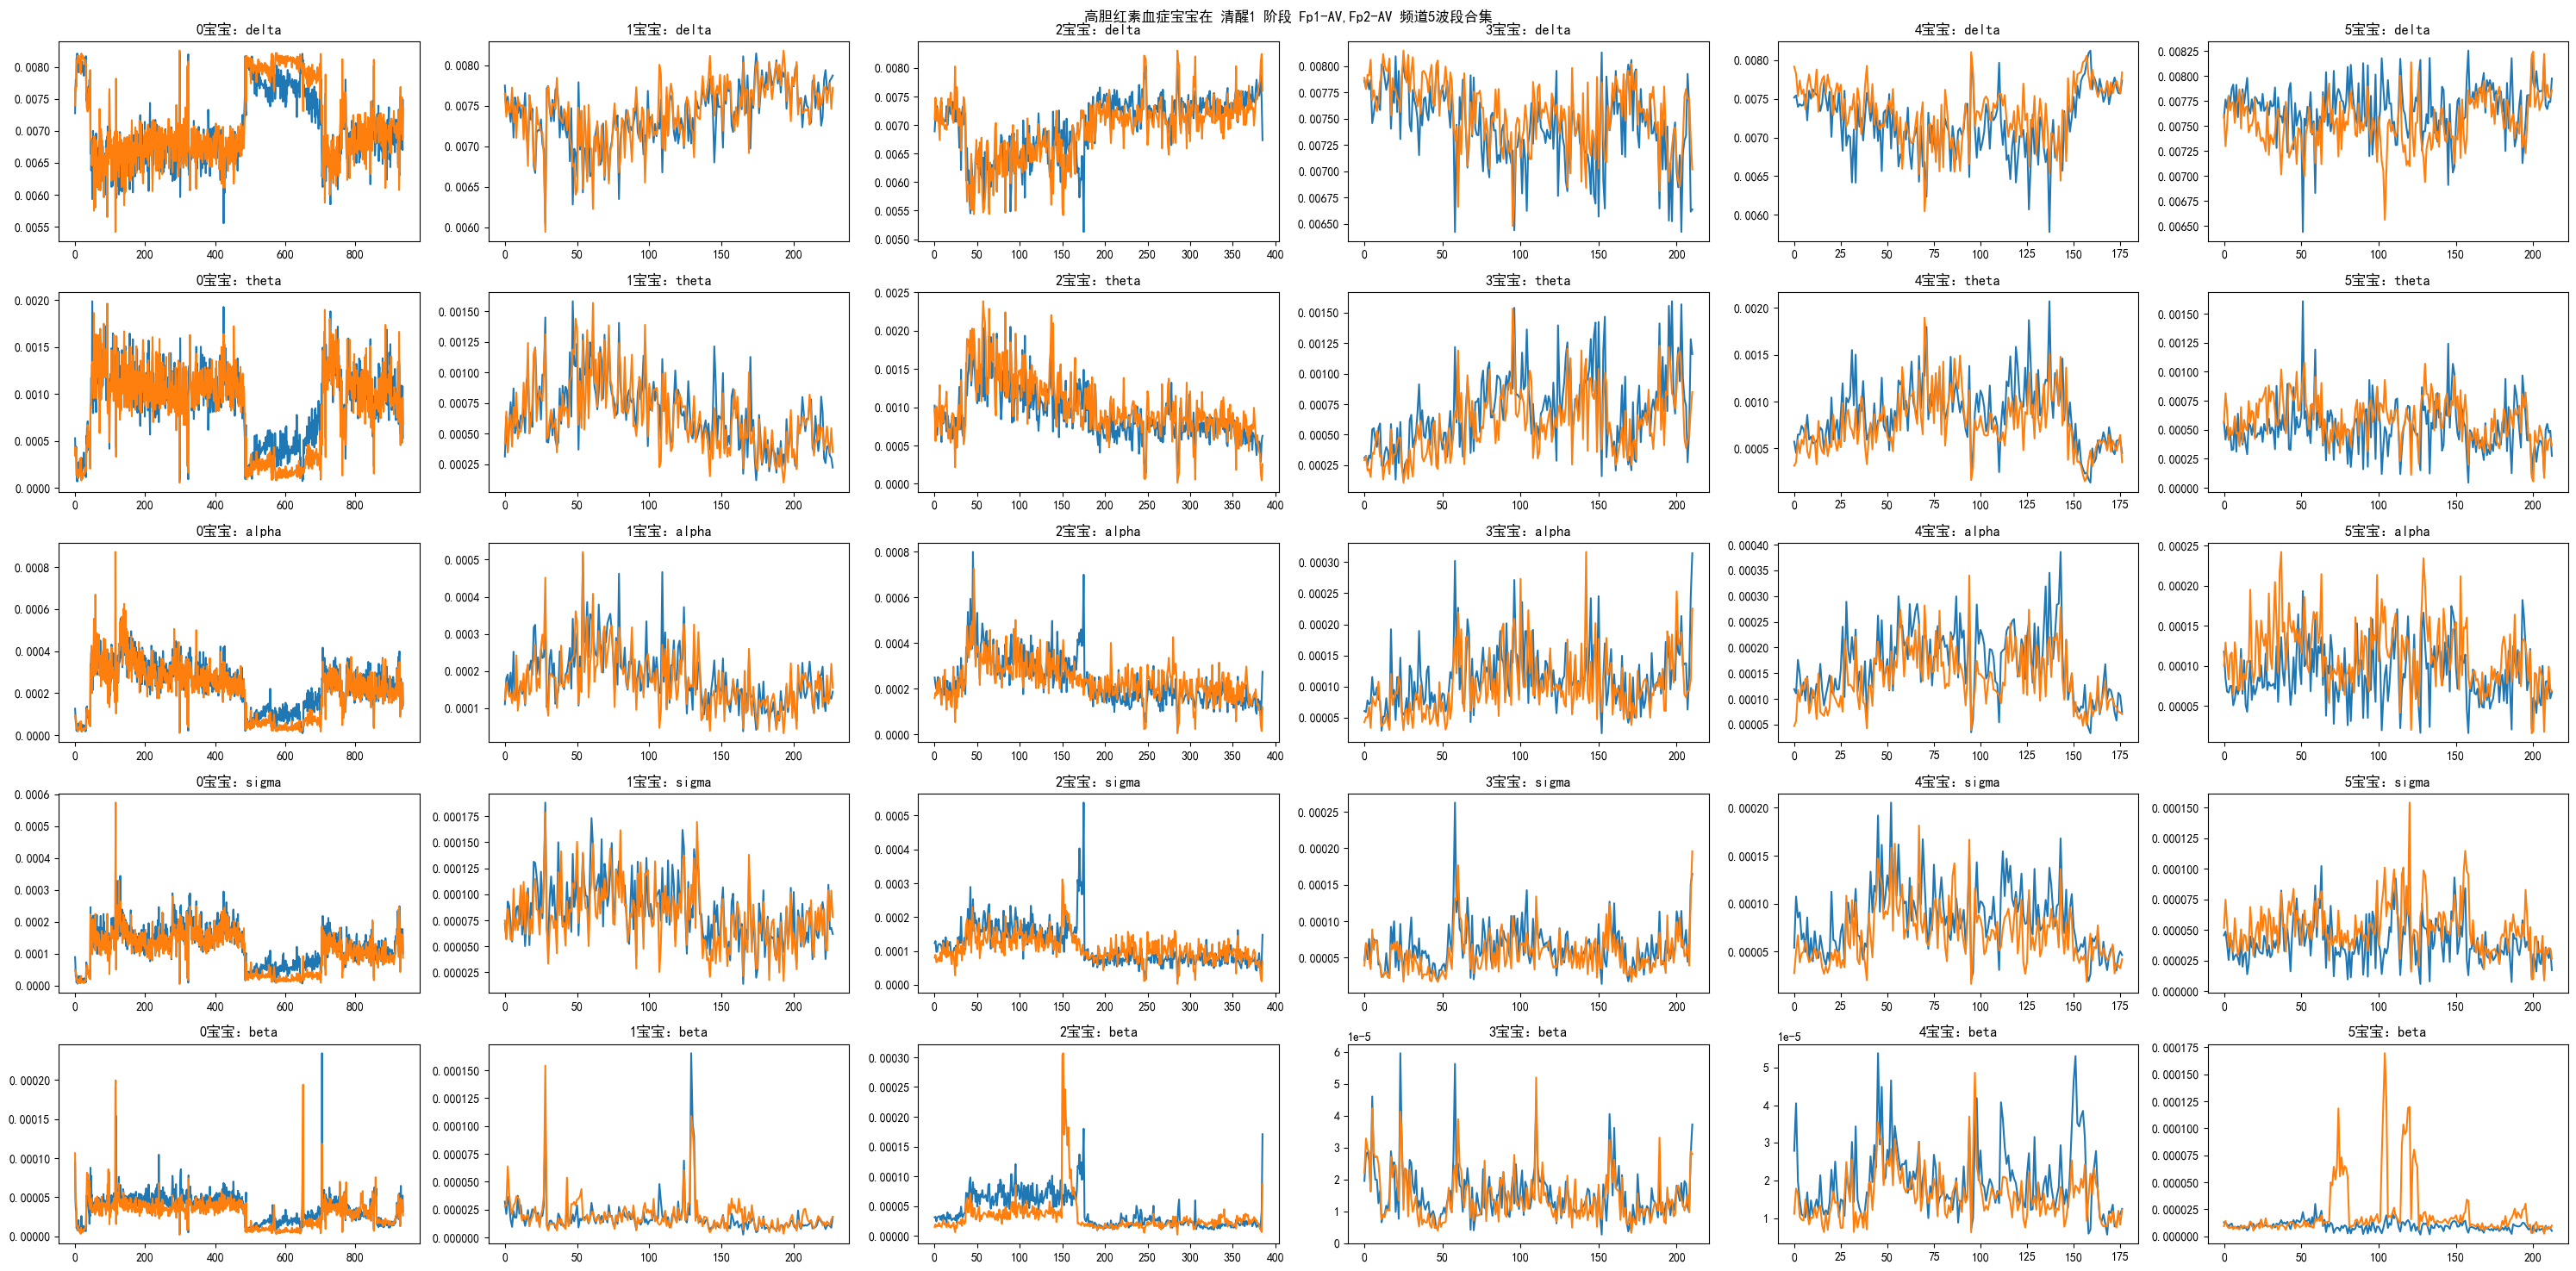

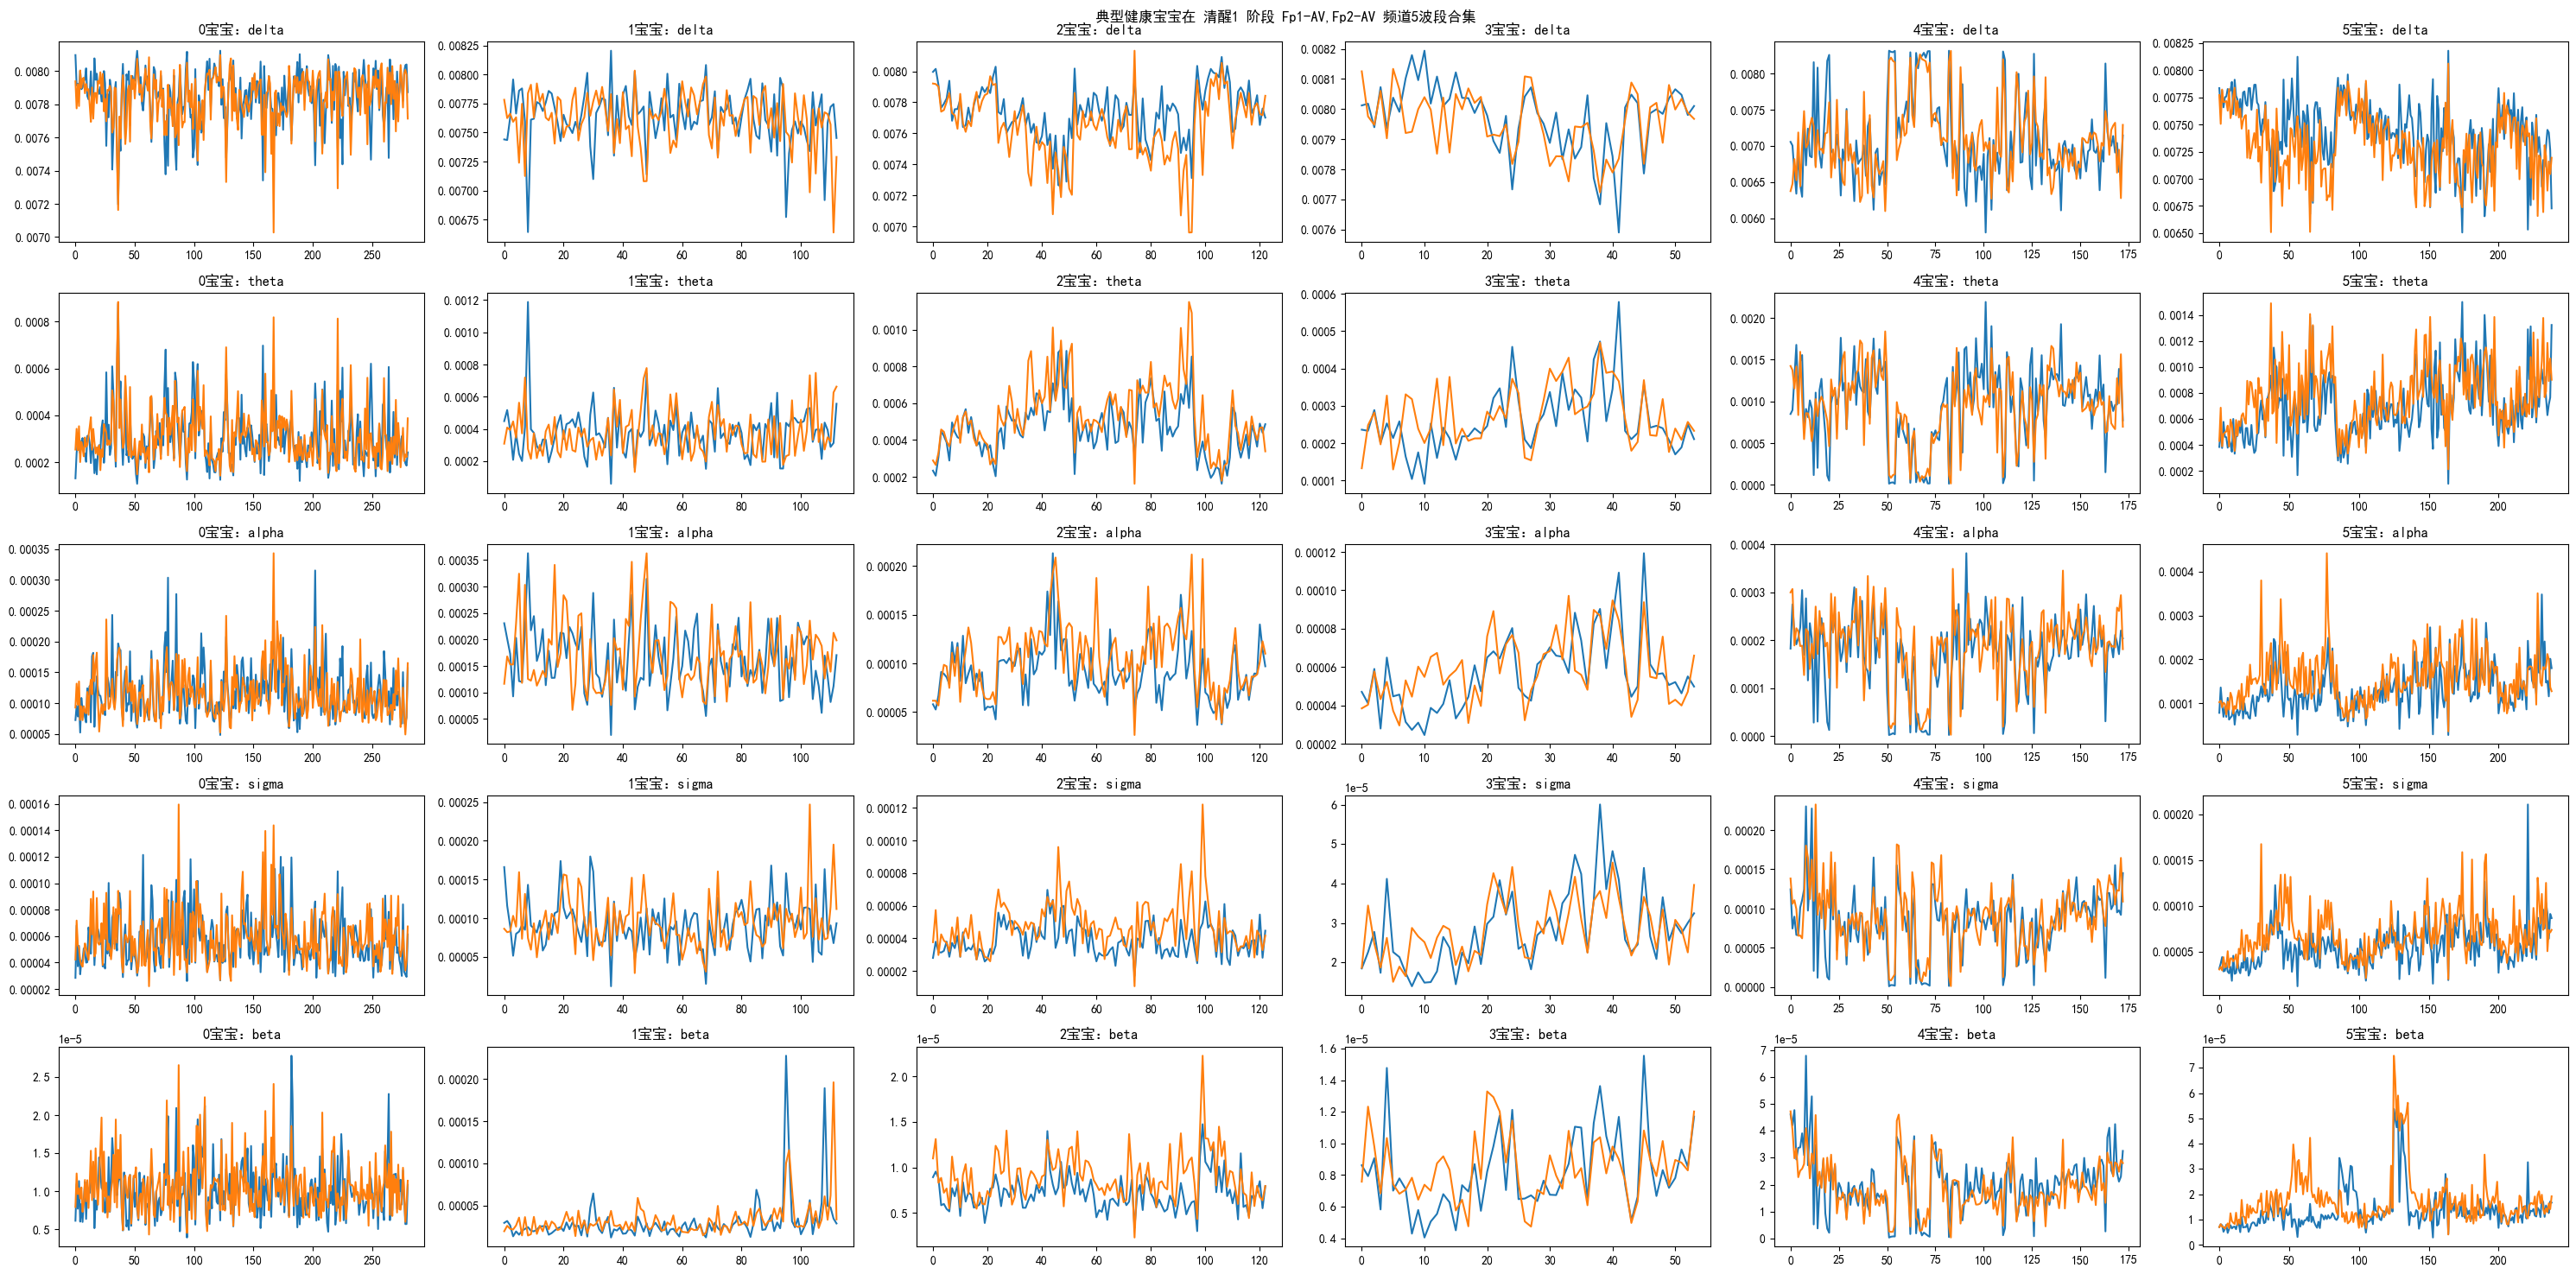

In [39]:
powerband_plotting_allin1(healthy_powerbands,sleep_stage[2],picks,'健康')
powerband_plotting_allin1(hyper6_powerbands,sleep_stage[2],picks,'高胆红素血症')
powerband_plotting_allin1(selected_healthy_powerbands,sleep_stage[2],picks,'典型健康')

# powerbands分析

In [ ]:
# healthy_powerband[j][i][:,0].sort()
# mid_index = len(healthy_powerband[j][i][:,0])//2
# result = round((healthy_powerband[j][i][:,0][mid_index]+healthy_powerband[j][i][:,0][~mid_index])/2,6)

In [94]:
def powerbands_analyz(healthy_powerband,hyper6_powerband):
    status,mean,std,upper,lower,mid,wave,outlier,count,outlier_ratio = [],[],[],[],[],[],[],[],[],[]
    waves = ['Δ波','θ波','α波','σ波','β波']
    for i in range(5):
        for j in range (12):
            if j<6 :
                #calculate healthy_powerband
                status.append( "健康")
                wave.append( waves[i])
                mean.append(np.mean(healthy_powerband[j][i][:,1]))
                std.append(np.std(healthy_powerband[j][i][:,1]))
                result = np.median(healthy_powerband[j][i][:,1])
                mid.append(result)

                arr = np.asarray(healthy_powerband[j][i][:,1])
                arr.sort()
                q1_x = np.percentile(arr,25,method='midpoint')
                q3_x = np.percentile(arr,75,method='midpoint')
                iqr = q3_x - q1_x

                up = q3_x + 1.5*iqr
                low = q1_x - 1.5*iqr
                upper.append(up)
                lower.append(low)
                
                nup = np.sum(arr>up)
                nup += np.sum(arr<low)
                outlier.append(nup)
                count.append(len(healthy_powerband[j][i][:,1]))
                outlier_ratio.append(nup/count[j+i*12])
            elif j>=6 and j<9:
                #calculate hyper6_powerband
                status.append( "换血")
                wave.append( waves[i])
                mean.append(np.mean(hyper6_powerband[j-6][i][:,1]))
                std.append(np.std(hyper6_powerband[j-6][i][:,1]))
                result = np.median(hyper6_powerband[j-6][i][:,1])
                mid.append(result)
                
                arr_hc = np.asarray(hyper6_powerband[j-6][i][:,1])
                arr_hc.sort()
                q1_hc = np.percentile(arr_hc,25,method='midpoint')
                q3_hc = np.percentile(arr_hc,75,method='midpoint')
                iqr = q3_hc - q1_hc

                up = q3_hc + 1.5*iqr
                low = q1_hc - 1.5*iqr
                upper.append(up)
                lower.append(low)
                
                nup = np.sum(arr_hc>up)
                nup += np.sum(arr_hc<low)
                outlier.append(nup)
                count.append(arr_hc.size)
                outlier_ratio.append(nup/count[j+i*12])
            else:
                #calculate hyper6_powerband
                status.append( "未换血")
                wave.append( waves[i])
                mean.append(np.mean(hyper6_powerband[j-6][i][:,1]))
                std.append(np.std(hyper6_powerband[j-6][i][:,1]))
                result = np.median(hyper6_powerband[j-6][i][:,1])
                mid.append(result)
                
                arr_huc = np.asarray(hyper6_powerband[j-6][i][:,1])
                arr_huc.sort()
                q1_huc = np.percentile(arr_huc,25,method='midpoint')
                q3_huc = np.percentile(arr_huc,75,method='midpoint')
                iqr = q3_huc - q1_huc

                up = q3_huc + 1.5*iqr
                low = q1_huc - 1.5*iqr
                upper.append(up)
                lower.append(low)
                
                nup = np.sum(arr_huc>up)
                nup += np.sum(arr_huc<low)
                outlier.append(nup)
                count.append(arr_huc.size)
                outlier_ratio.append(nup/count[j+i*12])
                
    mean = [element * 10000 for element in mean]
    std = [element * 10000 for element in std]
    mid = [element * 10000 for element in mid]
    upper = [element * 10000 for element in upper]
    lower = [element * 10000 for element in lower]
    df= pd.DataFrame({'status':status,'wave':wave,'median':mid,'mean':mean,'standard deviation':std,'upper boarder':upper,'lower boarder':lower,'outlier':outlier,'count':count,'out_ratio':outlier_ratio})         
    return df

In [114]:
df = powerbands_analyz(selected_healthy_powerbands,hyper6_powerbands)
# df.to_csv('.//saved_analyz_table//'+sleep_stage[0]+'//result.csv')
df

status wave     median       mean  standard deviation  upper boarder  \
0      健康   Δ波  78.707198  78.391447            1.538025      82.223061   
1      健康   Δ波  76.444726  76.174986            2.311606      82.124655   
2      健康   Δ波  76.539680  76.349704            2.158185      81.821828   
3      健康   Δ波  79.591302  79.550697            0.987297      82.548972   
4      健康   Δ波  70.228473  70.975669            5.064763      81.799928   
5      健康   Δ波  73.074048  73.046215            2.960793      81.570797   
6      换血   Δ波  69.185300  71.054762            6.239333      95.440447   
7      换血   Δ波  74.565893  74.087923            3.700284      83.903500   
8      换血   Δ波  70.296574  69.178139            5.308323      81.633767   
9     未换血   Δ波  75.910606  75.588660            3.159277      84.061001   
10    未换血   Δ波  73.621430  73.383462            3.693916      83.167708   
11    未换血   Δ波  75.164985  75.273016            2.487360      81.753572   
12     健康   θ波   2.851961   3.094130            1.138764       5.561665   
13     健康   θ波   3.509237   3.745262            1.380673       6.902927   
14     健康   θ波   5.111164   5.373952            1.851096       9.860877   
15     健康   θ波   2.635852   2.749321            0.799673       5.122817   
16     健康   θ波   9.891909   9.377765            4.201043      20.471010   
17     健康   θ波   7.499593   7.785612            2.432392      14.418529   
18     换血   θ波   9.667711   8.505213            4.440698      24.028378   
19     换血   θ波   6.002462   6.438470            2.789888      13.343090   
20     换血   θ波   9.376346  10.123476            4.025959      18.607707   
21    未换血   θ波   5.729516   5.903899            2.642150      12.798589   
22    未换血   θ波   7.274812   7.639455            3.103027      15.020355   
23    未换血   θ波   5.873348   5.916170            1.852696      11.049602   
24     健康   α波   1.077386   1.159044            0.386387       2.033273   
25     健康   α波   1.622451   1.714448            0.638491       3.367127   
26     健康   α波   1.049867   1.068506            0.348703       1.957650   
27     健康   α波   0.562818   0.590063            0.173916       1.009651   
28     健康   α波   2.013746   1.871130            0.761527       3.441896   
29     健康   α波   1.462003   1.579395            0.583502       2.986470   
30     换血   α波   2.279086   2.116373            1.248240       6.107060   
31     换血   α波   1.614349   1.726579            0.749925       3.427690   
32     换血   α波   2.340862   2.380552            0.883416       4.295076   
33    未换血   α波   0.911926   1.017875            0.486691       2.064418   
34    未换血   α波   1.349406   1.403552            0.566055       2.919206   
35    未换血   α波   1.083666   1.137069            0.400872       2.185683   
36     健康   σ波   0.550552   0.592219            0.198349       1.059135   
37     健康   σ波   0.898037   0.948242            0.331707       1.624462   
38     健康   σ波   0.456703   0.480414            0.148620       0.843489   
39     健康   σ波   0.284688   0.285067            0.074727       0.494791   
40     健康   σ波   0.902964   0.884738            0.405620       1.777507   
41     健康   σ波   0.639885   0.684672            0.256598       1.213796   
42     换血   σ波   1.166175   1.074047            0.636952       3.184870   
43     换血   σ波   0.788542   0.794458            0.293714       1.491710   
44     换血   σ波   1.030103   1.092209            0.405114       2.006499   
45    未换血   σ波   0.515594   0.560918            0.275222       1.216215   
46    未换血   σ波   0.614294   0.683112            0.300831       1.422180   
47    未换血   σ波   0.491992   0.521830            0.199015       0.971716   
48     健康   β波   0.103783   0.106497            0.034658       0.176373   
49     健康   β波   0.274281   0.324934            0.214804       0.562015   
50     健康   β波   0.087669   0.090391            0.026427       0.145496   
51     健康   β波   0.080303   0.084264            0.020547       0.138989   
52     健康   β波   0.175061   

# 点图生成

In [42]:
def powerbands_compair(healthy_powerbands,hyper6_powerbands,event,picks):
    waves = ['Δ波','θ波','α波','σ波','β波']
    fig,axs = plt.subplots(nrows=5,ncols=2,figsize=(60, 45))
    for i in range(10):
        rows = i //2
        cols = i % 2
        ax =axs[rows,cols]
        ax.set_xlim([0,400])
        if rows == 2:
            ax.set_ylim([0,0.0006])
        elif rows == 3:
            ax.set_ylim([0,0.0004])
        elif rows == 4:
            ax.set_ylim([0,0.0002])
        for j in range(12):
            if j < 6:
                ax.scatter(range(len(healthy_powerbands[j][rows][:,cols])),healthy_powerbands[j][rows][:,cols],label = "健康宝宝" + str(j))
                ax.set_title(picks[cols]+' '+waves[rows])
            elif j >= 6 and j < 9:
                ax.scatter(range(len(hyper6_powerbands[j-6][rows][:,cols])),hyper6_powerbands[j-6][rows][:,cols],label = "换血宝宝" + str((j-6)))
                ax.set_title(picks[cols]+' '+waves[rows])
            else:
                ax.scatter(range(len(hyper6_powerbands[j-6][rows][:,cols])),hyper6_powerbands[j-6][rows][:,cols],label = "未换血宝宝"+str((j-9)))
                ax.set_title(picks[cols]+' '+waves[rows])
    fig.suptitle("全体宝宝双通道五波段汇总图")
    plt.tight_layout()
    lines, labels = fig.axes[-1].get_legend_handles_labels()
    plt.legend(lines,labels,loc=1)
    plt.savefig('.\\saved_compair_result\\'+event+'\\宝宝合集.png',dpi=300,bbox_inches='tight')
    plt.show()
                        

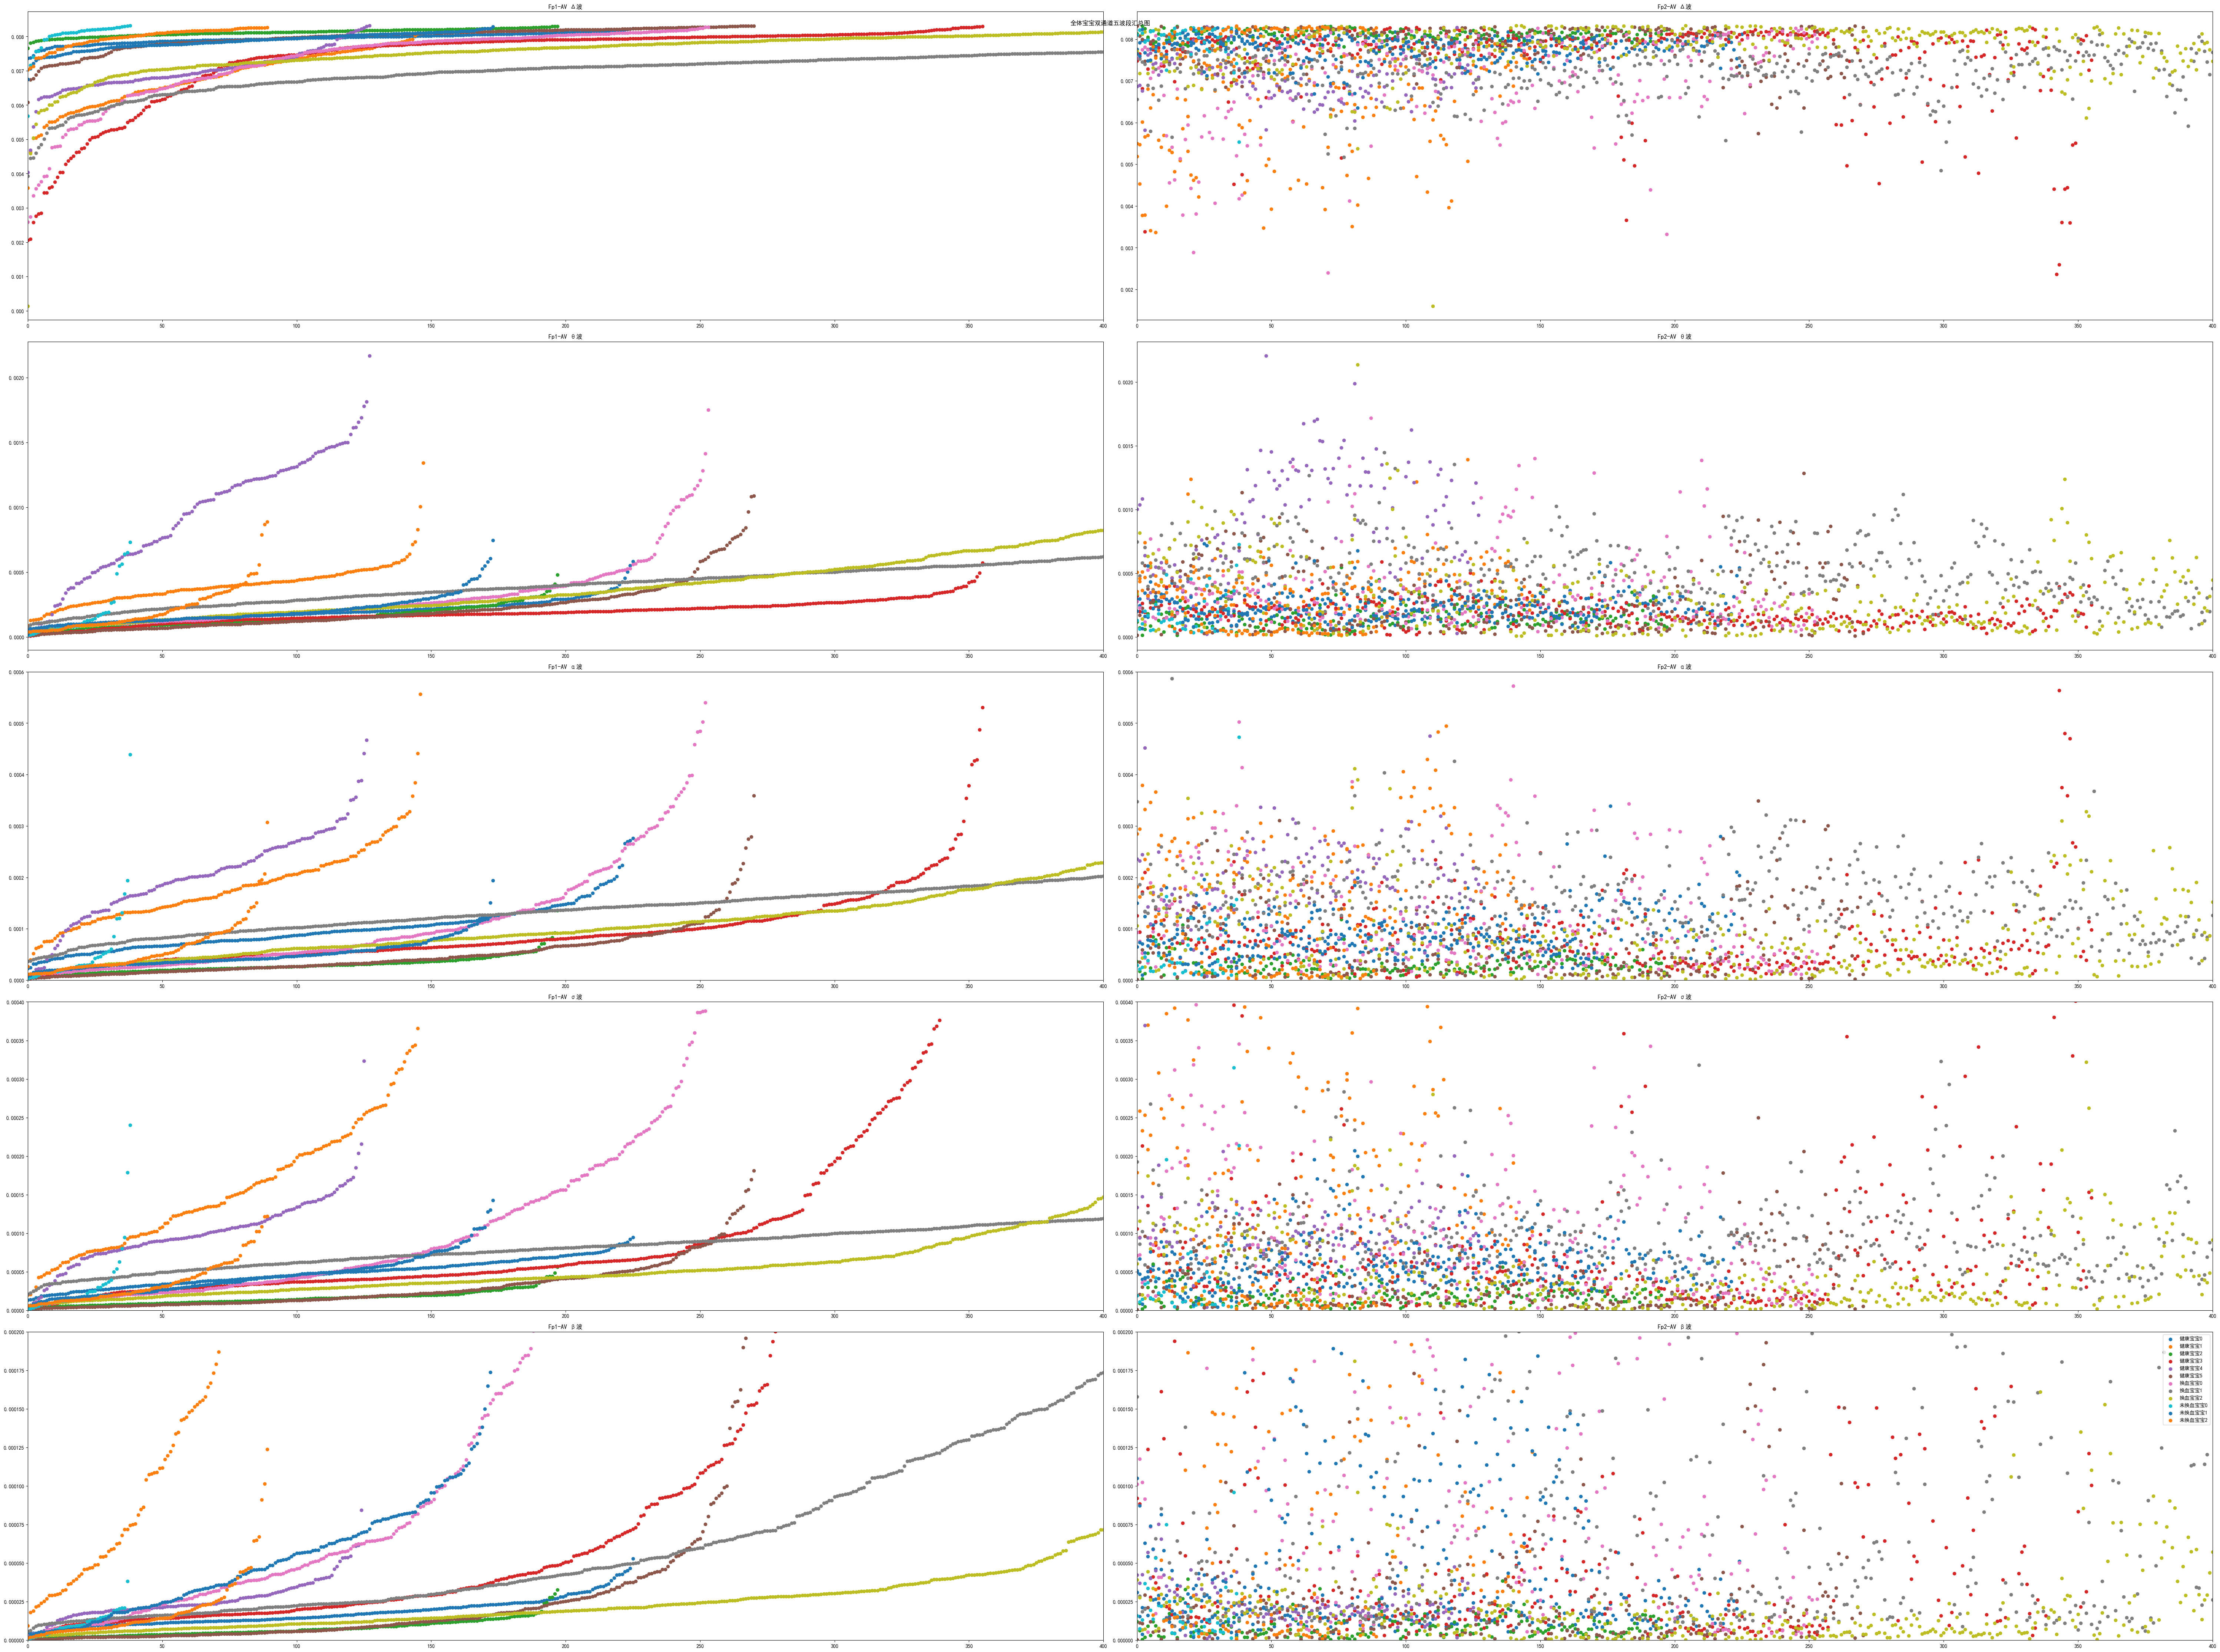

In [43]:
powerbands_compair(selected_healthy_powerbands,hyper6_powerbands,sleep_stage[2],picks)

# 箱图生成

In [97]:
def box_plot_analyz(healthy_powerbands,hyper6_powerbands,event,N,picks):
    """
    Parameters:
        N :{0,1} 通道编号
    -------------------------------------------------------
    """
    waves = ['Δ波','θ波','α波','σ波','β波']
    fig, axs = plt.subplots(nrows=5,ncols=1,figsize=(20,15))
        
    for i in range(5):
        ax = axs[i]
        if i == 2:
            ax.set_ylim([0,0.0006])
        elif i == 3:
            ax.set_ylim([0,0.0004])
        elif i == 4:
            ax.set_ylim([0,0.0002])
        all_data = []
        for j in range(12):
            if j<6:
                all_data.append(healthy_powerbands[j][i][:,N])
            elif j>=6 and j<9:
                all_data.append(hyper6_powerbands[j-6][i][:,N])
            else:
                all_data.append(hyper6_powerbands[j-6][i][:,N])
        ax.boxplot(all_data)
        ax.set_title(waves[i])
    fig.suptitle(event+'  '+picks[N]+" 5波段全部宝宝箱图分析")
    plt.savefig('.\\saved_boxplot_result\\'+event+'\\'+str(N)+'\\宝宝合集.png',dpi=600,bbox_inches='tight')
    plt.show()

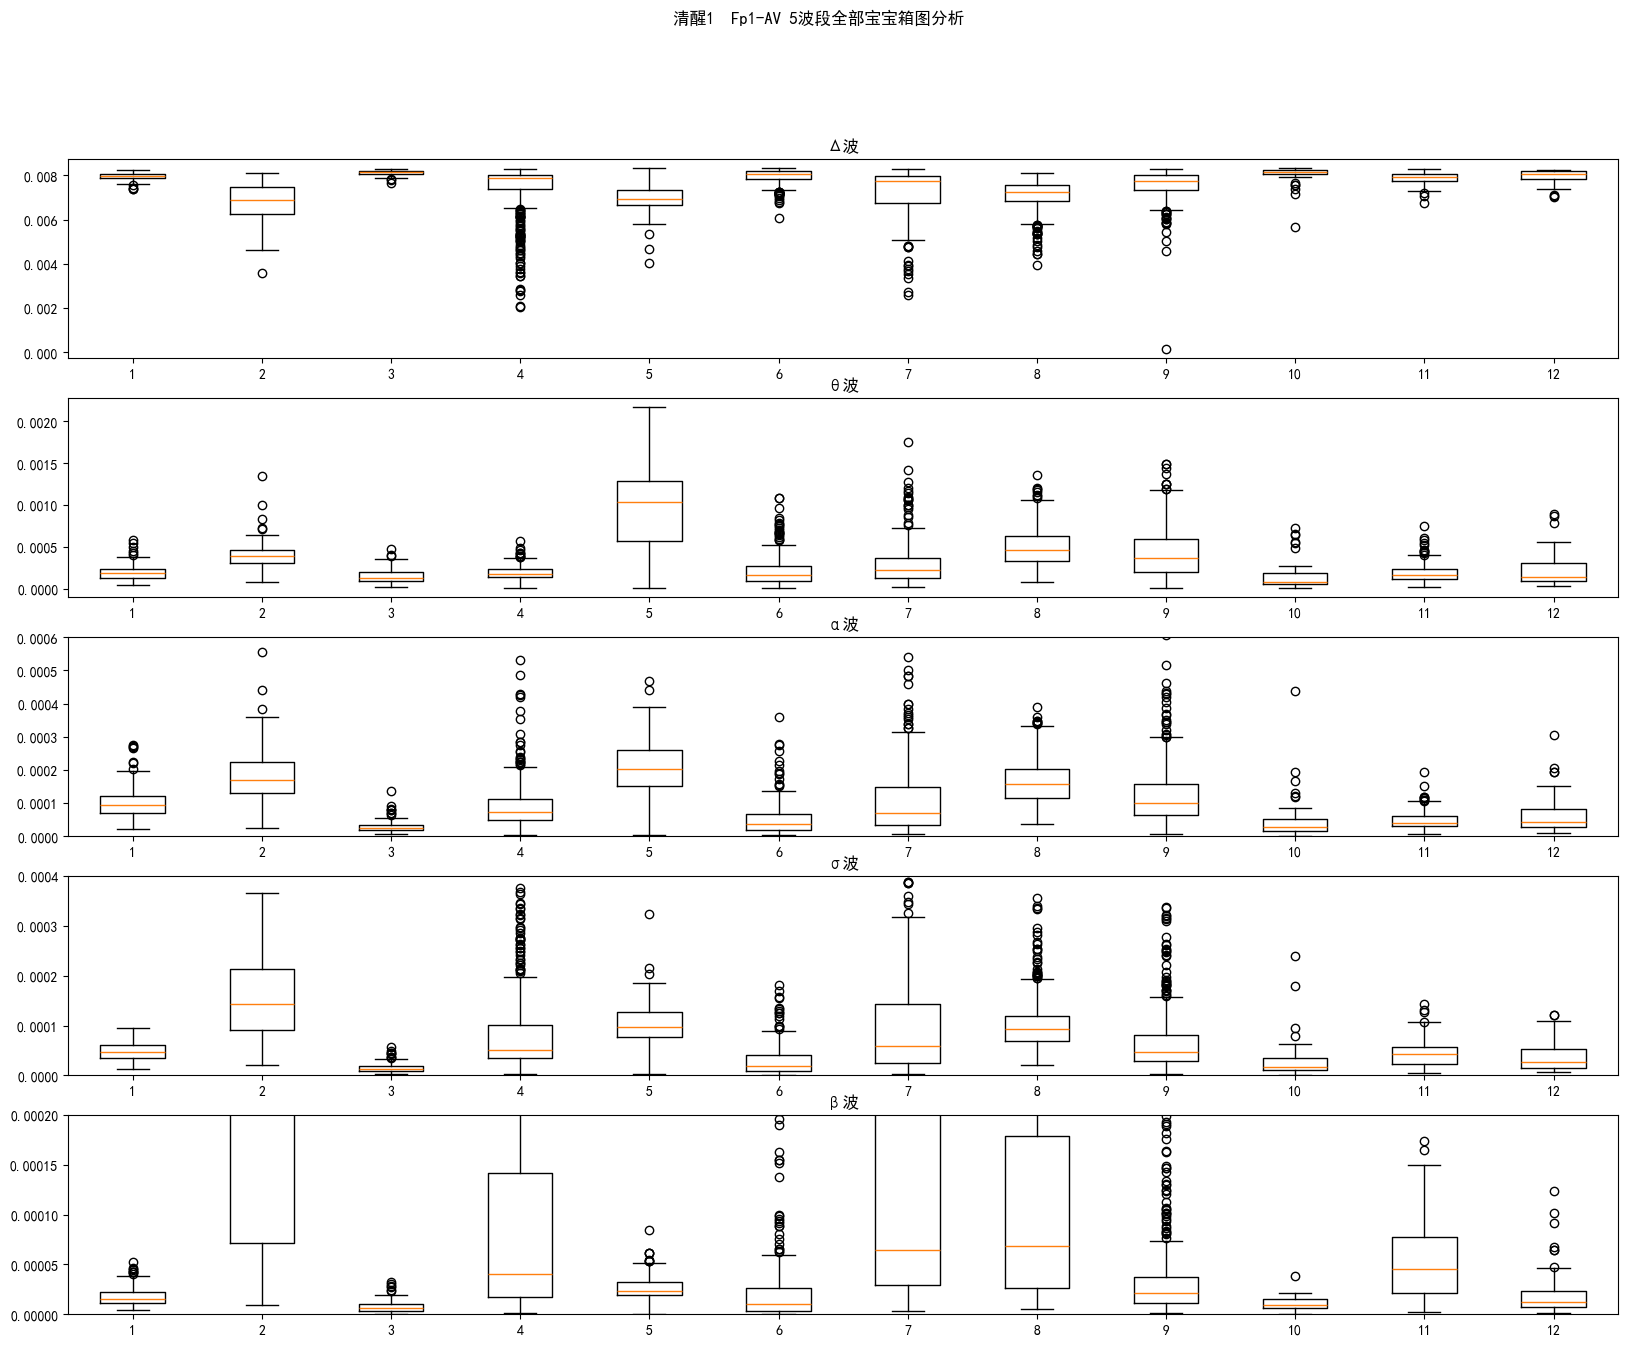

In [107]:
box_plot_analyz(selected_healthy_powerbands,hyper6_powerbands,sleep_stage[0],0,picks)

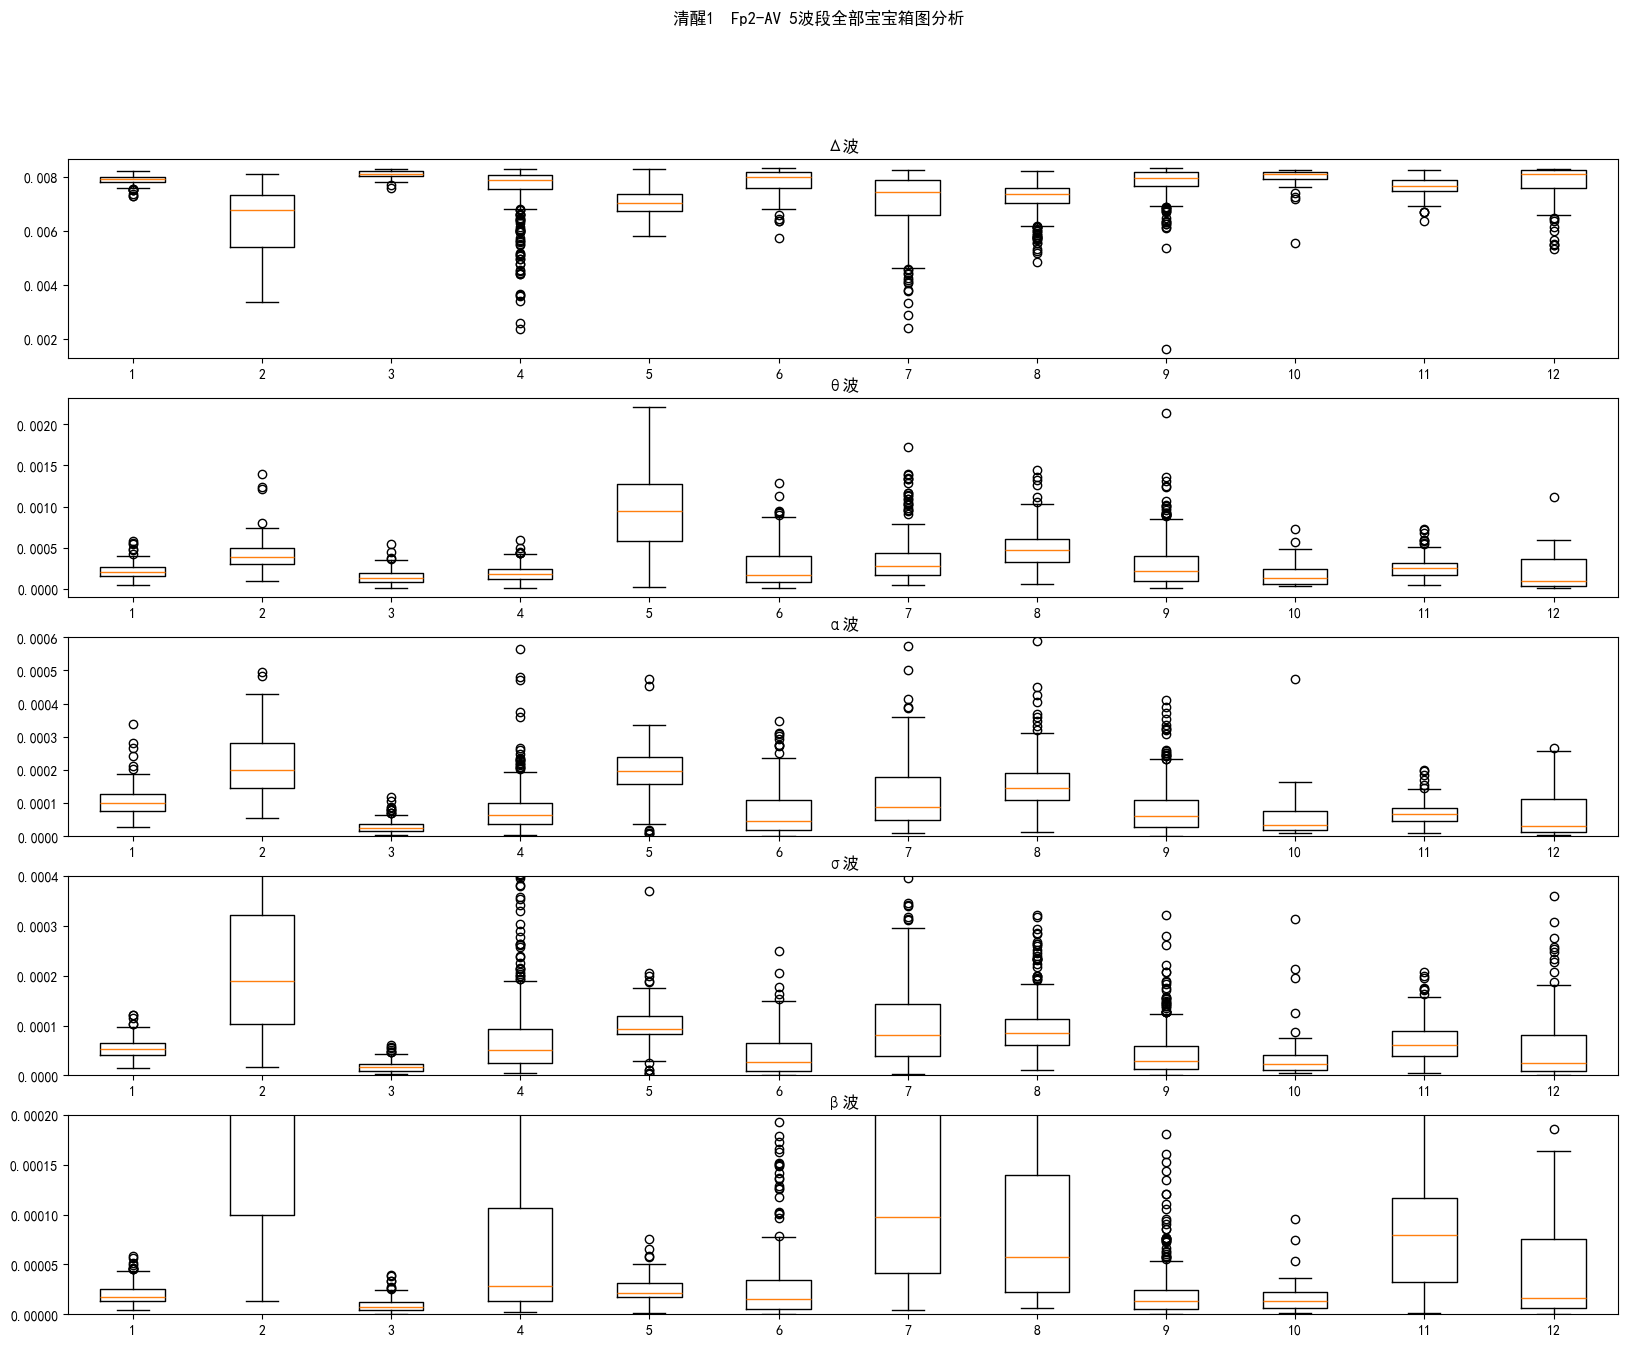

In [108]:
box_plot_analyz(selected_healthy_powerbands,hyper6_powerbands,sleep_stage[0],1,picks)

In [47]:
#powerbands_analyz(healthy_powerbands,hyper6_powerbands)

In [48]:
def eeg_power_band_test(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5 * n_channels]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],# qs
        "theta": [4.5, 8.5],# as
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    power_bands = []
    index = 0
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        power_bands.append(psds_band.reshape(len(psds), -1))
        

    return power_bands

In [49]:
labels = []
for epochs in epochs_hyper_6:
    labels.append(epochs.events[:,2])
colors = ['red','green','blue']

In [50]:
# index = 0
# for epochs in epochs_hyper_6:
#     powerbands=eeg_power_band_test(epochs)
#     label = labels[index]
#     length = len(label)
#     for i in range(len(powerbands)):
#         plt.plot(powerbands[i])
#         for j in range(length):
#             color = colors[label[j]-1]
#             plt.axvspan(xmin=j,xmax=j+1,facecolor=color,alpha=0.3)
#         plt.show()
#     print("---------------------------------------------")
#     index += 1

In [51]:
# for i in range(5):
#     healthy_powerbands_old = eeg_power_band_test(epochs_healthy[i])
#     for j in range(len(healthy_powerbands)):
#         plt.plot(healthy_powerbands[j])
#         plt.show()
#     print("-------------------------------------------------------------------------")